In [1]:
import json
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from load_dataset import TimeSeries

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.read_json('annotations.json')

,apple,bank,bee_waggle_6,bitcoin,brent_spot,businv,centralia,children_per_woman,co2_canada,construction,...,scanline_126007,scanline_42049,seatbelts,shanghai_license,uk_coal_employ,measles,unemployment_nl,us_population,usd_isk,well_log
6,[319],[],[],"[502, 580, 702, 747]","[219, 230, 288]","[119, 203, 215]","[3, 12]","[146, 177]","[80, 107]","[193, 217]",...,"[250, 404]","[54, 76, 77, 183, 185, 273, 275, 348, 360, 363]",NaN,[140],"[15, 28, 45, 60, 68, 80]",[],"[54, 116, 130, 132, 143, 171, 180]",[],"[115, 120]","[179, 255, 281, 311, 343, 402, 413, 422, 432, ..."
7,[319],[],[],NaN,NaN,[],[],NaN,"[80, 107, 133, 149, 164, 173]",[192],...,NaN,"[55, 77, 184, 275, 349, 363, 466]","[61, 169]",NaN,"[18, 47, 81]",[],NaN,[],"[35, 86, 106, 120]","[179, 255, 281, 312, 343, 402, 412, 422, 432]"
8,[319],[],[],[583],"[227, 381]","[119, 203]",[12],[146],"[80, 164]",[193],...,[251],"[185, 275]","[60, 169]",[146],[],[],[182],[],[120],"[179, 255, 282, 312, 343, 402, 413, 422, 432]"
9,"[53, 90, 197, 276, 319, 403, 463, 535]",NaN,"[182, 246]",NaN,"[86, 219, 230, 279, 375]","[119, 203, 213]","[4, 8, 12]",NaN,"[80, 110, 145, 164, 173]",NaN,...,NaN,"[54, 76, 184, 274, 349, 363, 466]",NaN,NaN,"[15, 27, 46, 68, 81]",[],NaN,[462],"[30, 40, 120]",NaN
10,[319],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],...,NaN,NaN,[],[146],NaN,NaN,"[131, 144, 181]",NaN,NaN,NaN
12,NaN,[],[],[597],"[169, 172, 217, 228, 287, 368, 382, 389, 409]",NaN,NaN,"[145, 168]",NaN,"[136, 205]",...,[],NaN,"[60, 169]",[145],NaN,[141],[],[460],NaN,"[177, 467]"
13,NaN,NaN,NaN,"[522, 579, 591, 629, 703, 747, 760]","[170, 180, 219, 229, 246, 271, 286, 379, 409, ...","[120, 202, 212]",[],"[146, 170, 180, 197]","[67, 80, 107, 134, 144, 163, 173]",NaN,...,"[106, 120, 153, 251, 267, 280, 291, 307, 316, ...","[52, 78, 183, 277, 346, 366, 464]","[60, 79, 169]","[108, 140]","[19, 28, 45, 68, 80]",NaN,"[54, 77, 114, 131, 138, 143, 171, 176, 180]",NaN,"[117, 123]","[4, 179, 255, 281, 311, 344, 402, 412, 422, 43..."
14,NaN,NaN,NaN,"[93, 522, 540, 701, 747, 760, 772]",NaN,NaN,NaN,"[146, 170]",NaN,NaN,...,[251],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Open questions
1. difference between Nan and []

In [3]:
annotator_df = pd.read_json('annotations.json')
annotator_df[['quality_control_2']]

,quality_control_2
6,[]
7,NaN
8,[98]
9,[99]
10,NaN
12,[97]
13,[97]
14,NaN


## Load quality_control_2 dataset

In [498]:
annotator_df = pd.read_json('annotations.json')
quality_control_2_df =  annotator_df[['quality_control_2']]
list2d = np.array(quality_control_2_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
quality_control_2_annotation_lst = list(itertools.chain.from_iterable(list2d))
(quality_control_2_annotation_lst)

[98, 99, 97, 97]

TimeSeries(name=quality_control_2, n_obs=283, n_dim=1)
   t            V1  date  is_CPD  time
0  0  1.000507e+06  1980       0  1980
1  1  9.961533e+05  1981       0  1981
2  2  9.949100e+05  1982       0  1982
3  3  9.920928e+05  1983       0  1983
4  4  9.833025e+05  1984       0  1984


<Figure size 960x480 with 0 Axes>

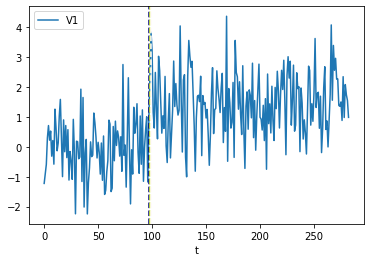

In [550]:
from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/quality_control_2/quality_control_2.json')
print(ts)
quality_control_2_df = ts.df
quality_control_2_df['is_CPD'] = np.where(quality_control_2_df.t.isin(quality_control_2_annotation_lst), 1,0)
    
print(rail_lines_df.head())

#quality_control_2_df['date'] =ts.datestr
#print(quality_control_2_df.dtypes)
#print(quality_control_2_df.head())
figure(figsize=(12, 6), dpi=80);
quality_control_2_df.plot('t', 'V1');

xposition = quality_control_2_df.loc[quality_control_2_df['is_CPD']==1][['t']].values
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(xposition))]

for xc,color in zip(xposition,colors):
    #plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=xc, color=color, linestyle='--')


## **1.1 `CUSUMDetector`**


CUSUM is a method to detect an up/down shift of means in a time series. Our implementation has two main steps:


1. **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point. The next changepoint is the location where the previous CUSUM time series is maximized (or minimized). This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.
2. **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1. The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  If we want to see all the changepoints, we can use the `return_all_changepoints` parameter in `CUSUMDetector` and set it to `True`.

Here are a few additional points worth mentioning:

* We assume there is at most one increase change point and at most one decrease change point. You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
* We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.


The full set of parameters for the `detector` method in `CUSUMDetector`, all of which are optional and have default values, are as follows: 
* **threshold**: float, significance level;
* **max_iter**: int, maximum iteration in finding the changepoint;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series;
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected;
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points;
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison;
* **magnitude_ratio**: float, comparable ratio;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones.

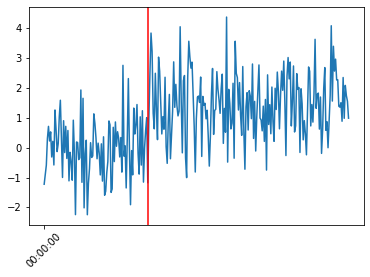

In [263]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector,MultiCUSUMDetector
from kats.consts import TimeSeriesData

df = quality_control_2_df
df['time']= df['t']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
detector = CUSUMDetector(tsd)
#change_points = detector.detector(return_all_changepoints=True,min_abs_change=0,threshold =0.01,magnitude_ratio= 0.5,delta_std_ratio=0.100)#start_point =10)
change_points = detector.detector(return_all_changepoints=True)#start_point =10)


plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [264]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000096, end_time: 1970-01-01 00:00:00.000000096, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e12c254f0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000281, end_time: 1970-01-01 00:00:00.000000281, confidence: 0.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e12bdf190>)]

Now let's look at the additional attributes of `CUSUMChangePoint` beyond those of `TimeSeriesChangePoint`:
* **direction**: str, the change point direction, either 'increase' or 'decrease';
* **cp_index**: int, the index of the change point;
* **mu0**: float, mean before the change point;
* **mu1**: float, mean after the change point;
* **delta**: float, mu1 - mu0;
* **llr_int**: float, the log likelihood ratio in interest window, or `inf` if not using an interet window;
* **llr**: float, the log likelihood ratio for the full time series;
* **regression_detected**: bool, is the change point detected by the algorithm (only relevant when `return_all_changepoints=True`);
* **stable_changepoint**: bool, indicates whether the algorithm converged to this point (rather than hitting the iteration limit);
* **p_value**: float, p-value for the likelihood ratio test;
* **p_value_int**: float, p-value for the likelihood ratio test in interest_window, or `nan` if not using an interest window.

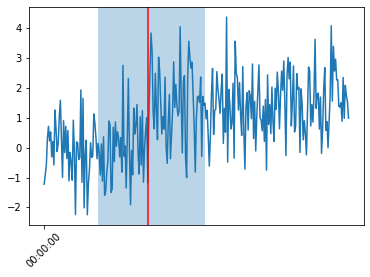

[(TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000096, end_time: 1970-01-01 00:00:00.000000096, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e12b86160>)]

In [268]:
change_points = detector.detector(interest_window=[50,150])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

change_points

## **1.2 BOCPDetector**

Bayesian Online Change Point Detection (BOCPD) is a method for detecting sudden changes in a time series that persist over time. Our implementation is faithful to ["Bayesian Online Changepoint Detection"](https://arxiv.org/abs/0710.3742) (Adams & McKay, 2007).  There are a coupple properties that distinguish BOCPD from the other change point detection methods supported in Kats:

* **Online Model:** This detection does not need to know the entire series apriori.  It only need to look a few steps ahead (specified by the `lag` parameter in the `detector` method) to make predictions, and it revises its predictions as new data arrives.  
* **Bayesian Model:** The user can specify prior beliefs about the probability of a changepoint (using the `changepoint_prior` paremeter in the `detector` method) and specify the the parameters of the underlying probability model that generates the time series (using the `model_parameters` parameter in the `detector` method).  Right now we support 3 diferent types of underlying probability models (specified using the `model` parameter in the `detector` method).

The basic idea of this detection method is uses Bayesian inference to decide if the next point is improbable.  This requires the user to specify (or use default values for) the **probability of a change point** and **underlying predictive model (UPM)** that generates the incoming data points in the time series.  Currently we support three different types of underlying models:
1. Normal Distribution (unknown mean, known variance)    
2. Trend Change Distribution    
3. Poisson Process Model    


The full set of parameters for the `detector` method in `BOCPDetector`, all of which are optional and have default values, are as follows: 

* **model**: This specifies the underlying probabilistic model (UPM) that generates the data within each segment.  Currently, allowed models are:
    * NORMAL_KNOWN_MODEL: Normal model with variance known. Use this to find level shifts in normally distributed data.
    * TREND_CHANGE_MODEL : This model assumes each segment is generated from ordinary linear regression. Use this model to understand changes in slope, or trend in time series.
    * POISSON_PROCESS_MODEL: This assumes a Poisson generative model. Use this for count data, where most of the values are close to zero.
\
* **model_parameters**: Model Parameters correspond to specific parameters for a specific model. They are defined in the NormalKnownParameters, TrendChangeParameters, PoissonModelParameters classes.

* **lag**: integer referring to the lag in reporting the changepoint. We report the changepoint after seeing "lag" number of data points. Higher lag gives greater certainty that this is indeed a changepoint. Lower lag will detect the changepoint faster. This is the trade-off.

* **changepoint_prior**: This is a Bayesian algorithm. Hence, this parameter specifies the prior belief on the probability that a given point is a changepoint. For example, if you believe 10% of your data will be a changepoint, you can set this to 0.1.

* **threshold**: We report the probability of observing the changepoint at each instant. The actual changepoints are obtained by denoting the points above this threshold to be a changepoint.

* **debug**: This surfaces additional information, such as the plots of predicted means and variances, which allows the user to see debug why changepoints were not properly detected.

total changepoints-->  2


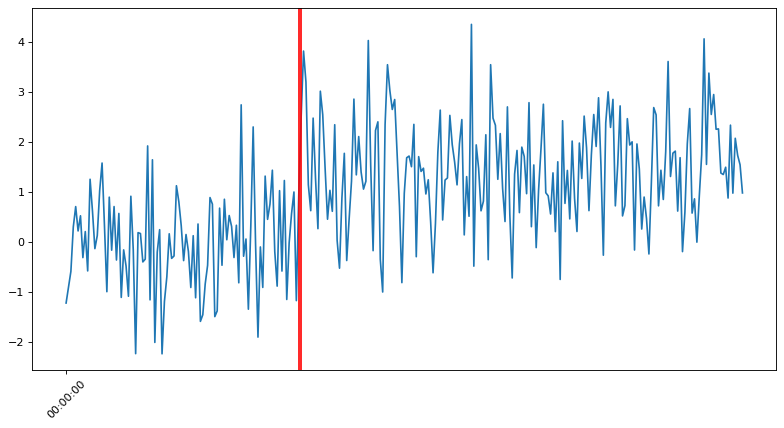

In [294]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=5,
    changepoint_prior=.1, #prior belief
    threshold=.2 #change it to 0.1, 3 cp detected
)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

The additional attributes of `BOCPDChangePoint` beyond those of `TimeSeriesChangePoint` are:
* **detector_type:** This will always be `kats.detectors.bocpd.BOCPDetector`
* **model:** The type of the underlying predictive model, either `NORMAL_KNOWN_MODEL`, `TREND_CHANGE_MODEL`, or `POISSON_PROCESS_MODEL`
* **ts_name**: the name of the time series

In [295]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000097, end_time: 1970-01-01T00:00:00.000000097, confidence: 0.7114402127292506),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e126586a0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000098, end_time: 1970-01-01T00:00:00.000000098, confidence: 0.2780507899878588),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e1284d6a0>)]

## **1.3 RobustStatDetector**

`RobustStatDetector`, like `CUSUMDetector`, is a change point detection algorithms that finds mean shifts.  It works as follows:
1. Smooth the time series using a moving average
2. Calculate the differences in the smoothed time series over a fixed number of points (specified by the `comparison_window` parameter in the `detector` method).
3. Calculate the z-scores and p-values for the differences calculated in step 2.  Return points where the p-value is smaller than a prescribed threshold (specified by the `p_value_cutoff` parameter in the dtector method`)

Unlike `CUSUMDetector`, `RobustStatDetector` can detect multiple change points in a single run.  After a basic example, we will show an example with multiple change points.


The full set of parameters for the `detector` method in `RobustStatDetector`, all of which are optional and have default values, are as follows: 
* **p_value_cutoff**: float, the p-value threshold to flag the change point; 
* **smoothing_window_size**: int, the length of the smoothing window;
* **comparison_window**: int, the step of the diff function, i.e. how many data points you want the algorithm look back to make the comparison.

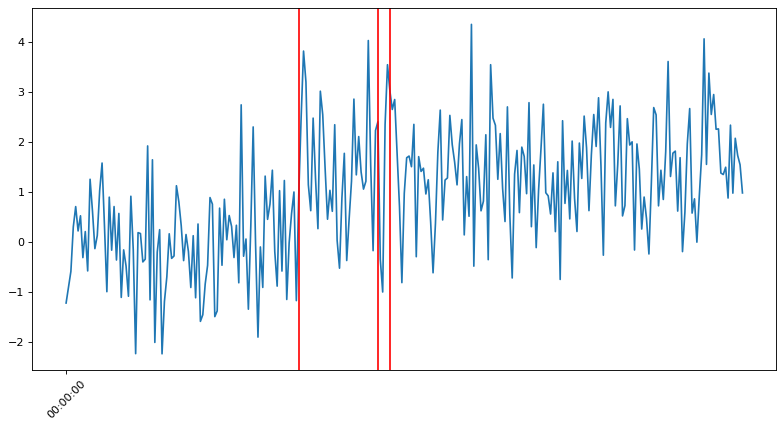

In [316]:
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 4e-3)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [317]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000097, end_time: 1970-01-01T00:00:00.000000097, confidence: 0.9965830630150646),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e1268ac40>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000130, end_time: 1970-01-01T00:00:00.000000130, confidence: 0.9995436681330089),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e129a7670>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000135, end_time: 1970-01-01T00:00:00.000000135, confidence: 0.9993595868980258),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e129a7640>)]

## Load quality_control_3 dataset

[178, 180, 179, 178, 179]
TimeSeries(name=quality_control_3, n_obs=366, n_dim=1)
t       int64
V1    float64
dtype: object
   t        V1
0  0  0.119256
1  1 -0.807736
2  2  1.533241
3  3 -0.697200
4  4  1.276436


<Figure size 960x480 with 0 Axes>

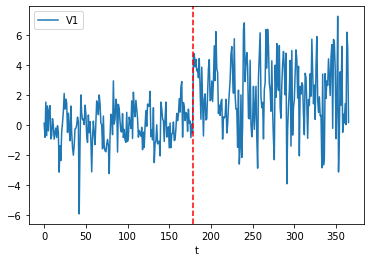

In [320]:
## Load quality_control_3 dataset

annotator_df = pd.read_json('annotations.json')
quality_control_3_df =  annotator_df[['quality_control_3']]
list2d = np.array(quality_control_3_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
quality_control_3_annotation_lst = list(itertools.chain.from_iterable(list2d))
print(quality_control_3_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/quality_control_3/quality_control_3.json')
print(ts)
quality_control_3_df = ts.df
#quality_control_3_df['date'] =ts.datestr
print(quality_control_3_df.dtypes)
print(quality_control_3_df.head())
figure(figsize=(12, 6), dpi=80);
quality_control_3_df.plot('t', 'V1');
quality_control_3_df['is_CPD'] = np.where(quality_control_3_df.t.isin(quality_control_3_annotation_lst), 1,0);
plt.axvline(quality_control_3_df.loc[quality_control_3_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--');

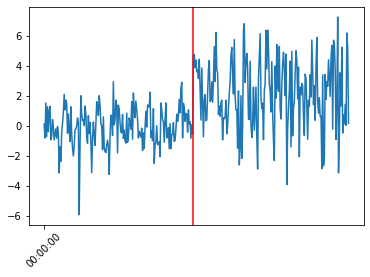

In [326]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = quality_control_3_df
df['time']= df['t']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(max_iter=100000,return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [327]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000178, end_time: 1970-01-01 00:00:00.000000178, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e12ad1a90>),
 (TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000364, end_time: 1970-01-01 00:00:00.000000364, confidence: 0.08380316593984738),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e12a959d0>)]

total changepoints-->  8


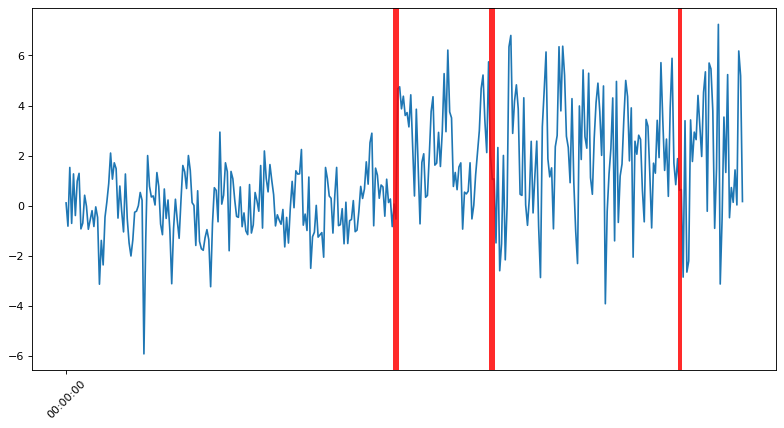

In [343]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=5,
    changepoint_prior=.1, #prior belief
    threshold=.1 #change it to 0.1, 3 cp detected
)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [345]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000177, end_time: 1970-01-01T00:00:00.000000177, confidence: 0.18829295655254977),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e12ac45b0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000178, end_time: 1970-01-01T00:00:00.000000178, confidence: 0.42743485705875073),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e12ced070>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000179, end_time: 1970-01-01T00:00:00.000000179, confidence: 0.5479127977798447),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e11e51df0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000229, end_time: 1970-01-01T00:00:00.000000229, confidence: 0.11677010964753305),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e11e51850>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000230, end_time: 1970-01-01T00:00:00.000000230, confidence: 0.14956325599015036),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e1222fe80

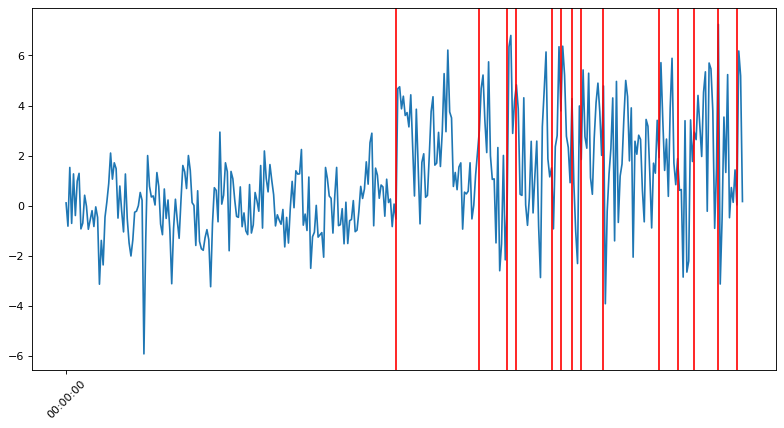

In [371]:
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 0.03)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [372]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000178, end_time: 1970-01-01T00:00:00.000000178, confidence: 0.9815493601105212),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e1177aa60>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000223, end_time: 1970-01-01T00:00:00.000000223, confidence: 0.9920016081449852),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e11771580>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000238, end_time: 1970-01-01T00:00:00.000000238, confidence: 0.9999687359039442),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e116d0df0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000243, end_time: 1970-01-01T00:00:00.000000243, confidence: 0.9807018900414491),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e116d0940>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000262, end_time: 1970-01-01T00:00:00.000000262, confiden

## Load quality_control_4 dataset

In [373]:
ts = TimeSeries.from_json('datasets/quality_control_4/quality_control_4.json')
ts

TimeSeries(name=quality_control_4, n_obs=500, n_dim=1)

[338, 159, 238, 342, 468, 340]
t       int64
V1    float64
dtype: object
   t         V1  is_CPD
0  0  12.200946       0
1  1  12.666373       0
2  2  11.886026       0
3  3  13.059346       0
4  4  12.435695       0


<Figure size 960x480 with 0 Axes>

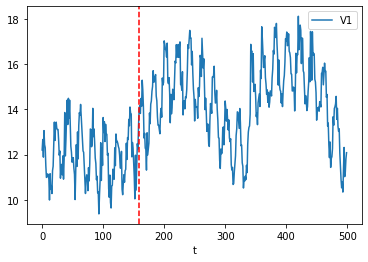

In [375]:
## Load quality_control_4 dataset
annotator_df = pd.read_json('annotations.json')
quality_control_4_df =  annotator_df[['quality_control_4']]
list2d = np.array(quality_control_4_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
quality_control_4_annotation_lst = list(itertools.chain.from_iterable(list2d))
print(quality_control_4_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/quality_control_4/quality_control_4.json')
quality_control_4_df = ts.df
#quality_control_4_df['date'] =ts.datestr
print(quality_control_4_df.dtypes)

figure(figsize=(12, 6), dpi=80);
quality_control_4_df.plot('t', 'V1')
quality_control_4_df['is_CPD'] = np.where(quality_control_4_df.t.isin(quality_control_4_annotation_lst), 1,0);
plt.axvline(quality_control_4_df.loc[quality_control_4_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--');
print(quality_control_4_df.head())

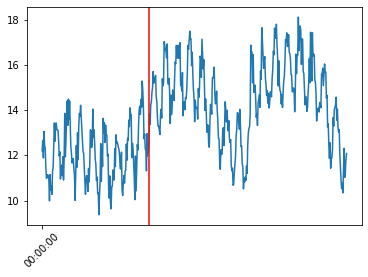

In [379]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = quality_control_4_df
df['time']= df['t']
tsd = TimeSeriesData(df.loc[:,['time','V1']])



detector = CUSUMDetector(tsd)
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [380]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000175, end_time: 1970-01-01 00:00:00.000000175, confidence: 1.0),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e115c48e0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000469, end_time: 1970-01-01 00:00:00.000000469, confidence: 0.9994417521208496),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e115d8ca0>)]

total changepoints-->  24


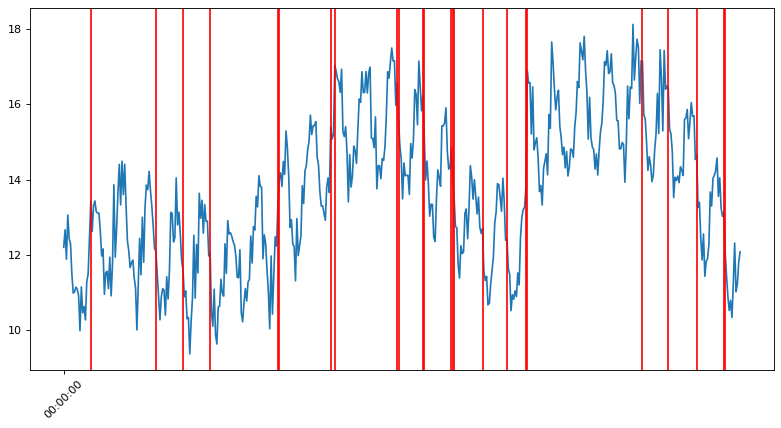

In [397]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=1,
    changepoint_prior=.5, #prior belief
    threshold=.3 
)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [398]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000020, end_time: 1970-01-01T00:00:00.000000020, confidence: 0.4267081176837137),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e11afca00>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000068, end_time: 1970-01-01T00:00:00.000000068, confidence: 0.37151905369684934),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e121bf130>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000088, end_time: 1970-01-01T00:00:00.000000088, confidence: 0.3299139259012902),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e116137f0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000108, end_time: 1970-01-01T00:00:00.000000108, confidence: 0.6471508297711887),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e126b67c0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000158, end_time: 1970-01-01T00:00:00.000000158, confidence: 0.4497252346594965),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7f2e126b6e20>),

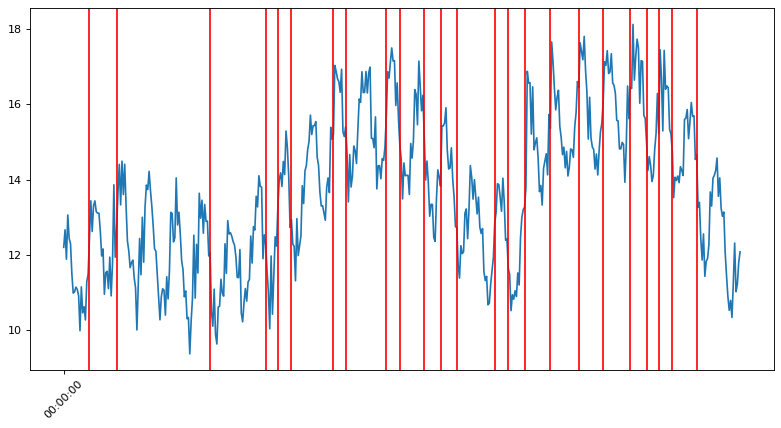

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000019, end_time: 1970-01-01T00:00:00.000000019, confidence: 0.9566208921374252),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e150cffd0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000039, end_time: 1970-01-01T00:00:00.000000039, confidence: 0.9626215146726208),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e12d319d0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000108, end_time: 1970-01-01T00:00:00.000000108, confidence: 0.9682951643528532),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e1512e100>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000149, end_time: 1970-01-01T00:00:00.000000149, confidence: 0.9511640204259667),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e124ab3d0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000158, end_time: 1970-01-01T00:00:00.000000158, confiden

In [402]:
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 5e-2)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

change_points

In [393]:
"""
Rail Lines Total Kilometers
Interval Training Running Race
UK Driver Deaths


"""

'\nRail Lines Total Kilometers\nInterval Training Running Race\nUK Driver Deaths\n\n\n'

## Load quality_control_5 dataset

In [403]:
ts = TimeSeries.from_json('datasets/quality_control_5/quality_control_5.json')
ts

TimeSeries(name=quality_control_5, n_obs=325, n_dim=1)

In [85]:
annotator_df.columns

Index(['apple', 'bank', 'bee_waggle_6', 'bitcoin', 'brent_spot', 'businv',
       'centralia', 'children_per_woman', 'co2_canada', 'construction',
       'debt_ireland', 'gdp_argentina', 'gdp_croatia', 'gdp_iran', 'gdp_japan',
       'global_co2', 'homeruns', 'iceland_tourism', 'jfk_passengers',
       'lga_passengers', 'nile', 'occupancy', 'ozone', 'quality_control_1',
       'quality_control_2', 'quality_control_3', 'quality_control_4',
       'quality_control_5', 'rail_lines', 'ratner_stock', 'robocalls',
       'run_log', 'scanline_126007', 'scanline_42049', 'seatbelts',
       'shanghai_license', 'uk_coal_employ', 'measles', 'unemployment_nl',
       'us_population', 'usd_isk', 'well_log'],
      dtype='object')

t       int64
V1    float64
dtype: object
   t        V1  is_CPD
0  0 -0.991944       0
1  1 -0.853575       0
2  2 -0.026521       0
3  3 -0.595666       0
4  4 -1.527999       0


<Figure size 960x480 with 0 Axes>

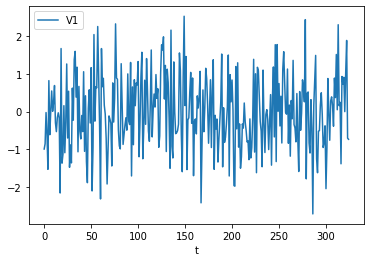

In [419]:
## Load quality_control_5 dataset
annotator_df = pd.read_json('annotations.json')
quality_control_5_df =  annotator_df[['quality_control_5']]
list2d = np.array(quality_control_5_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
quality_control_5_annotation_lst = list(itertools.chain.from_iterable(list2d))
(quality_control_5_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/quality_control_5/quality_control_5.json')
quality_control_5_df = ts.df
#quality_control_5_df['date'] =ts.datestr
print(quality_control_5_df.dtypes)

figure(figsize=(12, 6), dpi=80);
quality_control_5_df.plot('t', 'V1')
quality_control_5_df['is_CPD'] = np.where(quality_control_5_df.t.isin(quality_control_5_annotation_lst), 1,0);
#plt.axvline(quality_control_5_df.loc[quality_control_5_df['is_CPD']==1][['t']].values[0], color='red', linestyle='--');
print(quality_control_5_df.head())

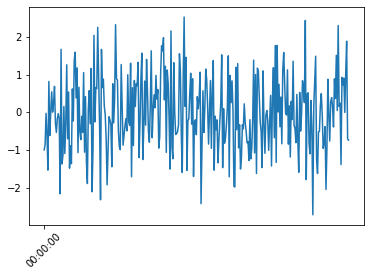

In [420]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = quality_control_5_df
df['time']= df['t']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [421]:
change_points

[(TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000029, end_time: 1970-01-01 00:00:00.000000029, confidence: 0.8285075413482257),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e118d0d00>),
 (TimeSeriesChangePoint(start_time: 1970-01-01 00:00:00.000000158, end_time: 1970-01-01 00:00:00.000000158, confidence: 0.5842290992399124),
  <kats.detectors.cusum_detection.CUSUMMetadata at 0x7f2e115c0910>)]

total changepoints-->  0


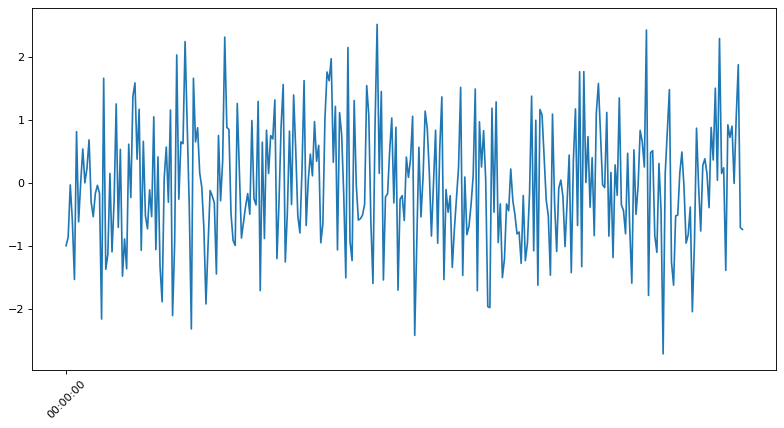

In [422]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=1,
    changepoint_prior=.5, #prior belief
    threshold=.1 
)

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

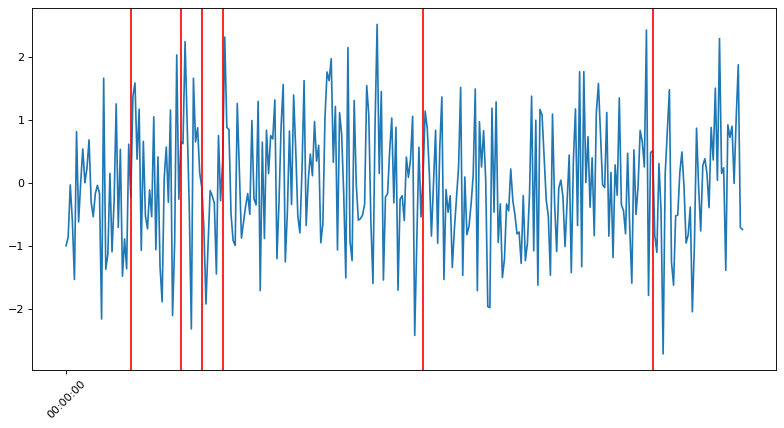

[(TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000031, end_time: 1970-01-01T00:00:00.000000031, confidence: 0.9973513999783213),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e11af28e0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000055, end_time: 1970-01-01T00:00:00.000000055, confidence: 0.9990526926264317),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e11af6eb0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000065, end_time: 1970-01-01T00:00:00.000000065, confidence: 0.9957215869026362),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e11af6460>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000075, end_time: 1970-01-01T00:00:00.000000075, confidence: 0.9952512545678349),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7f2e1209bfa0>),
 (TimeSeriesChangePoint(start_time: 1970-01-01T00:00:00.000000171, end_time: 1970-01-01T00:00:00.000000171, confiden

In [428]:
from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 1e-2)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

change_points

In [426]:

"""
Rail Lines Total Kilometers
Interval Training Running Race
UK Driver Deaths
"""

'\nRail Lines Total Kilometers\nInterval Training Running Race\nUK Driver Deaths\n'

## Load rail_lines dataset

In [501]:
ts = TimeSeries.from_json('datasets/rail_lines/rail_lines.json')
print(ts)

## Load rail_lines dataset
annotator_df = pd.read_json('annotations.json')
rail_lines_df =  annotator_df[['rail_lines']]
list2d = np.array(rail_lines_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
rail_lines_annotation_lst = list(itertools.chain.from_iterable(list2d))
print(rail_lines_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/rail_lines/rail_lines.json')
rail_lines_df = ts.df
rail_lines_df['date'] =ts.datestr

rail_lines_df['is_CPD'] = np.where(rail_lines_df.t.isin(rail_lines_annotation_lst), 1,0)
    
print(rail_lines_df.head())

TimeSeries(name=rail_lines, n_obs=37, n_dim=1)
[10, 25, 10, 26, 10, 25, 25, 26, 25]
   t            V1  date  is_CPD
0  0  1.000507e+06  1980       0
1  1  9.961533e+05  1981       0
2  2  9.949100e+05  1982       0
3  3  9.920928e+05  1983       0
4  4  9.833025e+05  1984       0


     t            V1  date  is_CPD  time
10  10  9.770744e+05  1990       1    10
25  25  9.893299e+05  2005       1    25
26  26  1.062033e+06  2006       1    26


<Figure size 960x480 with 0 Axes>

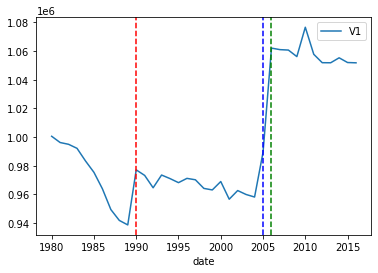

In [505]:
print(rail_lines_df.loc[rail_lines_df['is_CPD']==1])

figure(figsize=(12, 6), dpi=80);
rail_lines_df.plot('date', 'V1')

xposition = rail_lines_df.loc[rail_lines_df['is_CPD']==1][['t']].values
colors=['red','blue','green','black']
for xc,color in zip(xposition,colors):
    #plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=xc, color=color, linestyle='--')

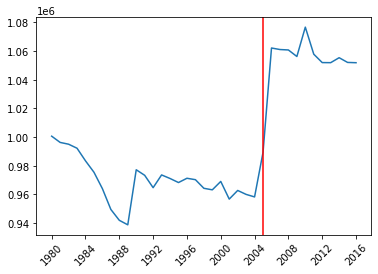

[(TimeSeriesChangePoint(start_time: 2005-01-01 00:00:00, end_time: 2005-01-01 00:00:00, confidence: 1.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e1055b3a0>), (TimeSeriesChangePoint(start_time: 1981-01-01 00:00:00, end_time: 1981-01-01 00:00:00, confidence: 0.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e103d0dc0>)]



In [507]:
#--------------------------------------

# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = rail_lines_df
df['time']= df['date']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)
print()

[(TimeSeriesChangePoint(start_time: 2006-01-01T00:00:00.000000000, end_time: 2006-01-01T00:00:00.000000000, confidence: 0.9799998825517523), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e103c7820>)]

total changepoints-->  1


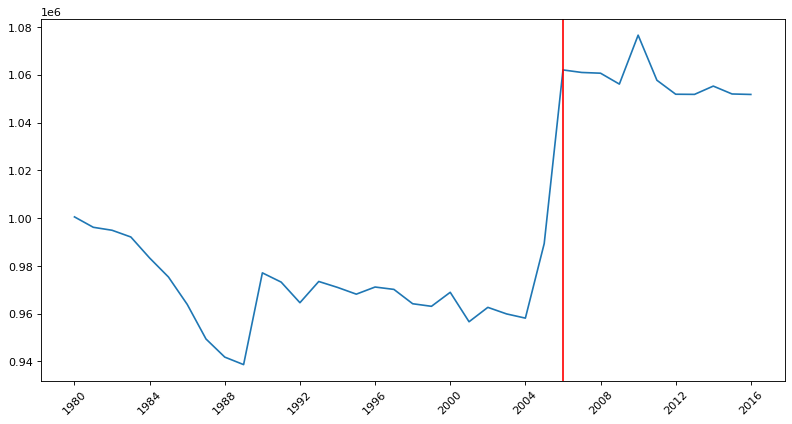

In [508]:
#--------------------------------------

from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=1,
    changepoint_prior=.5, #prior belief
    threshold=.1 
)
print(change_points)
print()

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()


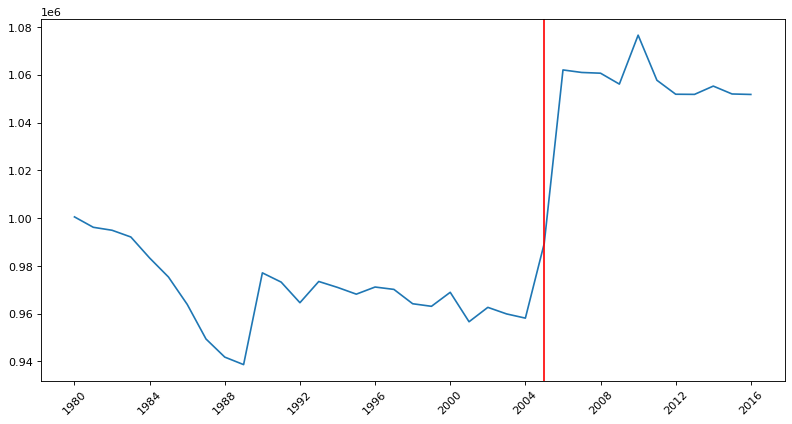

[(TimeSeriesChangePoint(start_time: 2005-01-01T00:00:00.000000000, end_time: 2005-01-01T00:00:00.000000000, confidence: 0.9936783583683463), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e103ba160>)]


In [509]:
#--------------------------------------

from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 1e-2)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

## INterval training dataset

TimeSeries(name=run_log, n_obs=376, n_dim=2)
[60, 96, 114, 174, 204, 240, 258, 317, 60, 96, 114, 177, 204, 240, 258, 317, 60, 96, 114, 174, 204, 240, 258, 317, 2, 60, 96, 114, 174, 204, 240, 258, 317]
['2018-07-31 18:22:38' '2018-07-31 18:27:29' '2018-07-31 18:30:29'
 '2018-07-31 18:31:59' '2018-07-31 18:36:59' '2018-07-31 18:37:14'
 '2018-07-31 18:39:29' '2018-07-31 18:42:29' '2018-07-31 18:44:04'
 '2018-07-31 18:49:04']


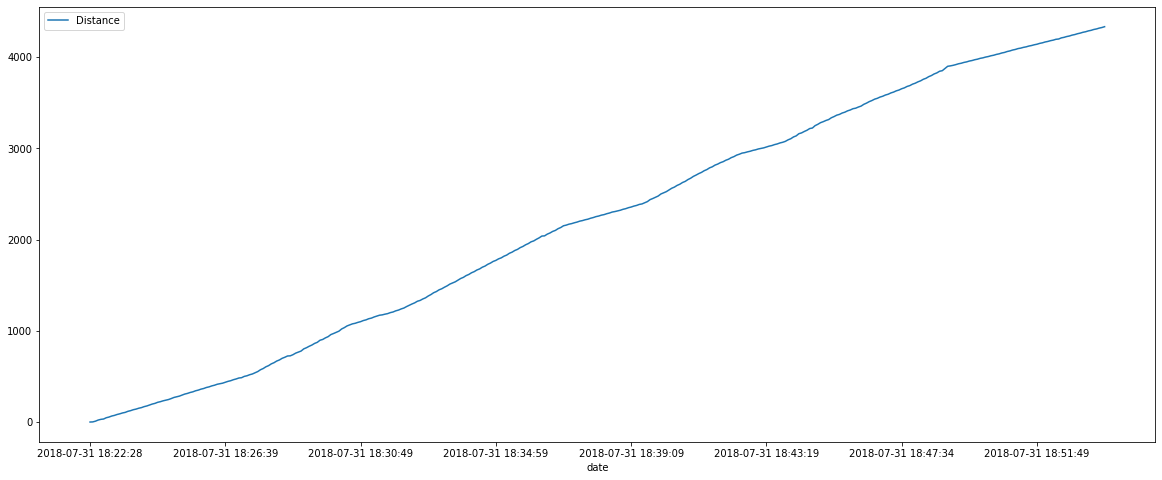

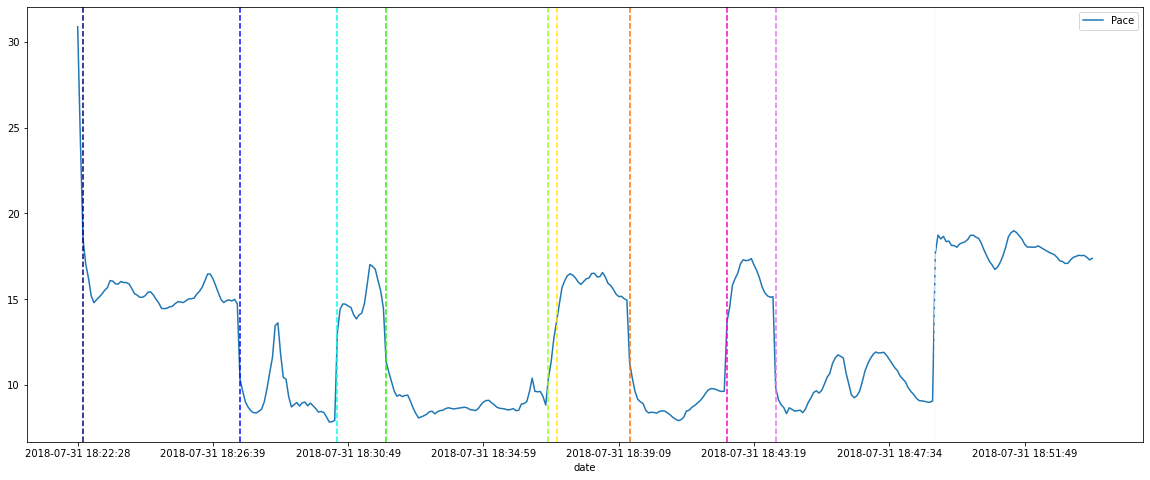

In [554]:


ts = TimeSeries.from_json('datasets/run_log/run_log.json')
print(ts)

## Load run_log dataset
annotator_df = pd.read_json('annotations.json')
run_log_df =  annotator_df[['run_log']]
list2d = np.array(run_log_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
run_log_annotation_lst = list(itertools.chain.from_iterable(list2d))
print(run_log_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/run_log/run_log.json')
run_log_df = ts.df
run_log_df['date'] =ts.datestr

run_log_df['is_CPD'] = np.where(run_log_df.t.isin(run_log_annotation_lst), 1,0)
    
#print(run_log_df.head())

print(run_log_df.loc[run_log_df['is_CPD']==1]['date'].values)


run_log_df.plot('date', 'Distance',figsize=(20,8))
run_log_df.plot('date', 'Pace',figsize=(20,8))

xposition = run_log_df.loc[run_log_df['is_CPD']==1][['t']].values
#colors=['red','blue','green','black']
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(xposition))]

for xc,color in zip(xposition,colors):
    #plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=xc, color=color, linestyle='--')

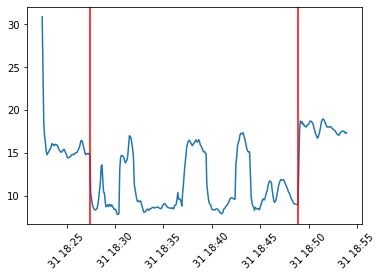

[(TimeSeriesChangePoint(start_time: 2018-07-31 18:48:54, end_time: 2018-07-31 18:48:54, confidence: 1.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e0f6876d0>), (TimeSeriesChangePoint(start_time: 2018-07-31 18:27:24, end_time: 2018-07-31 18:27:24, confidence: 0.9999999999077707), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e0f64cd60>)]



In [552]:
#--------------------------------------

# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = run_log_df
df['time']= df['date']
tsd = TimeSeriesData(df.loc[:,['time','Pace']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)
print()


[(TimeSeriesChangePoint(start_time: 2018-07-31T18:22:33.000000000, end_time: 2018-07-31T18:22:33.000000000, confidence: 0.979999999955762), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e65e130>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:22:38.000000000, end_time: 2018-07-31T18:22:38.000000000, confidence: 0.9477391887229399), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e7663a0>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:27:24.000000000, end_time: 2018-07-31T18:27:24.000000000, confidence: 0.9440532983972847), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e75cf70>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:27:29.000000000, end_time: 2018-07-31T18:27:29.000000000, confidence: 0.8745524667474448), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e75ce50>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:30:29.000000000, end_time: 2018-07-31T18:30:29.000000000, confidence: 0.9722814008693458), <kats.detectors.bocpd.BOCPDMetadata object a

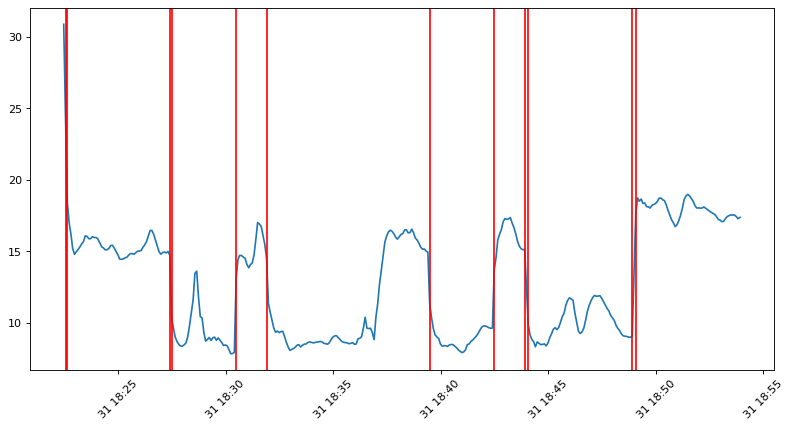

In [569]:
#--------------------------------------

from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=1,
    changepoint_prior=.1, #prior belief
    threshold=.8
)
print(change_points)
print()

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

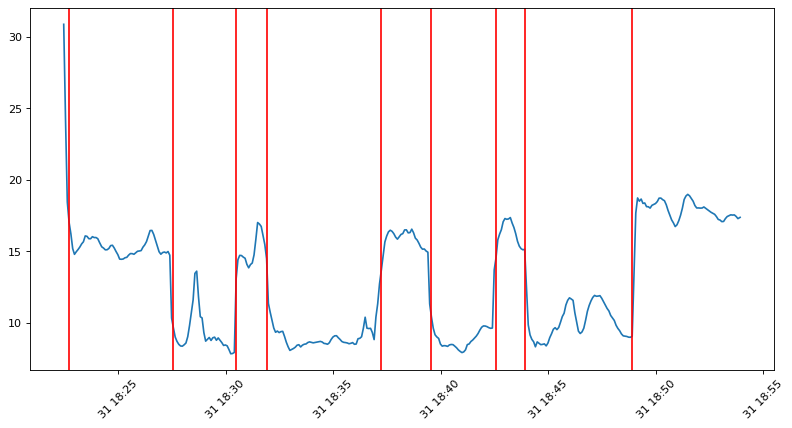

[(TimeSeriesChangePoint(start_time: 2018-07-31T18:22:43.000000000, end_time: 2018-07-31T18:22:43.000000000, confidence: 0.9994452035713595), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0f43dd60>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:27:34.000000000, end_time: 2018-07-31T18:27:34.000000000, confidence: 0.9942294723193676), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0fcd1850>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:30:29.000000000, end_time: 2018-07-31T18:30:29.000000000, confidence: 0.9972633803464346), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0f429dc0>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:31:54.000000000, end_time: 2018-07-31T18:31:54.000000000, confidence: 0.9916795398112948), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0f599d00>), (TimeSeriesChangePoint(start_time: 2018-07-31T18:37:14.000000000, end_time: 2018-07-31T18:37:14.000

In [561]:
#--------------------------------------

from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 1e-2)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

## UK Driver deaths dataset

TimeSeries(name=seatbelts, n_obs=192, n_dim=1)
[61, 169, 60, 169, 60, 169, 60, 79, 169]
   t     KSI     date  is_CPD
0  0  1687.0  1969-01       0
1  1  1508.0  1969-02       0
2  2  1507.0  1969-03       0
3  3  1385.0  1969-04       0
4  4  1632.0  1969-05       0
['1974-01' '1974-02' '1975-08' '1983-02']


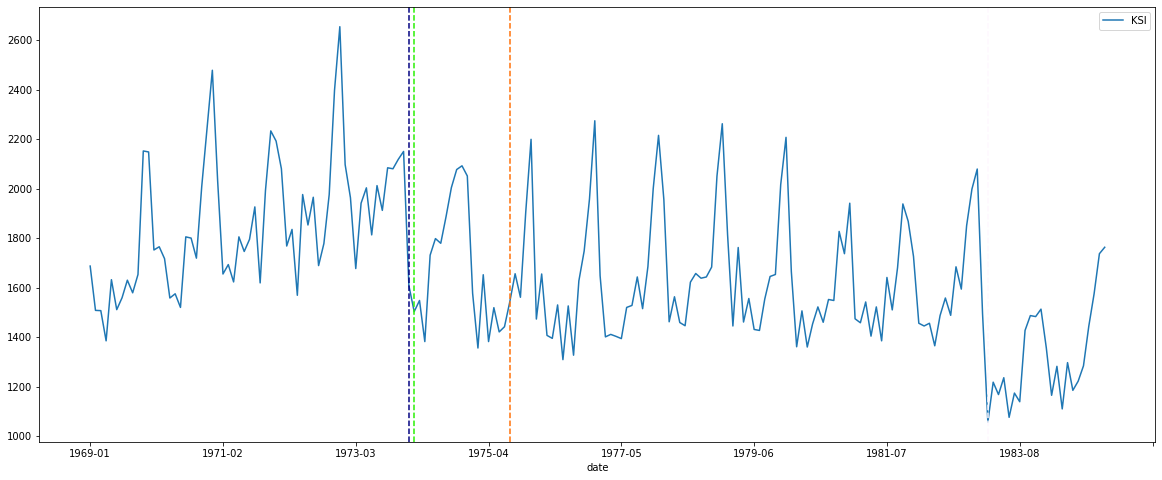

In [573]:

ts = TimeSeries.from_json('datasets/seatbelts/seatbelts.json')
print(ts)

## Load seatbelts dataset
annotator_df = pd.read_json('annotations.json')
seatbelts_df =  annotator_df[['seatbelts']]
list2d = np.array(seatbelts_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
seatbelts_annotation_lst = list(itertools.chain.from_iterable(list2d))
print(seatbelts_annotation_lst)

from load_dataset import TimeSeries
ts = TimeSeries.from_json('datasets/seatbelts/seatbelts.json')
seatbelts_df = ts.df
seatbelts_df['date'] =ts.datestr

seatbelts_df['is_CPD'] = np.where(seatbelts_df.t.isin(seatbelts_annotation_lst), 1,0)
    
print(seatbelts_df.head())

print(seatbelts_df.loc[seatbelts_df['is_CPD']==1]['date'].values)


seatbelts_df.plot('date', 'KSI',figsize=(20,8))


xposition = seatbelts_df.loc[seatbelts_df['is_CPD']==1][['t']].values
#colors=['red','blue','green','black']
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(xposition))]

for xc,color in zip(xposition,colors):
    #plt.axvline(x=xc, color='k', linestyle='--')
    plt.axvline(x=xc, color=color, linestyle='--')

#--------------------------------------

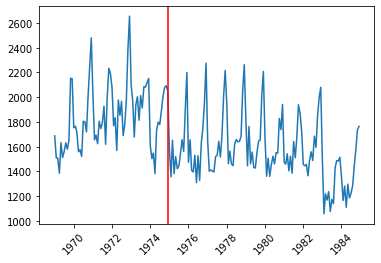

[(TimeSeriesChangePoint(start_time: 1969-09-01 00:00:00, end_time: 1969-09-01 00:00:00, confidence: 0.5255888273327565), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e0e151f10>), (TimeSeriesChangePoint(start_time: 1974-12-01 00:00:00, end_time: 1974-12-01 00:00:00, confidence: 0.9999999999810323), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f2e0e32d0d0>)]



In [581]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData

df = seatbelts_df
df['time']= df['date']
tsd = TimeSeriesData(df.loc[:,['time','KSI']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)
print()


[(TimeSeriesChangePoint(start_time: 1969-11-01T00:00:00.000000000, end_time: 1969-11-01T00:00:00.000000000, confidence: 0.6053972057231131), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e046ca0>), (TimeSeriesChangePoint(start_time: 1974-12-01T00:00:00.000000000, end_time: 1974-12-01T00:00:00.000000000, confidence: 0.7943291331624269), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e0469d0>), (TimeSeriesChangePoint(start_time: 1982-12-01T00:00:00.000000000, end_time: 1982-12-01T00:00:00.000000000, confidence: 0.8437016259131899), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e046280>), (TimeSeriesChangePoint(start_time: 1983-01-01T00:00:00.000000000, end_time: 1983-01-01T00:00:00.000000000, confidence: 0.467572877936692), <kats.detectors.bocpd.BOCPDMetadata object at 0x7f2e0e046a00>)]

total changepoints-->  4


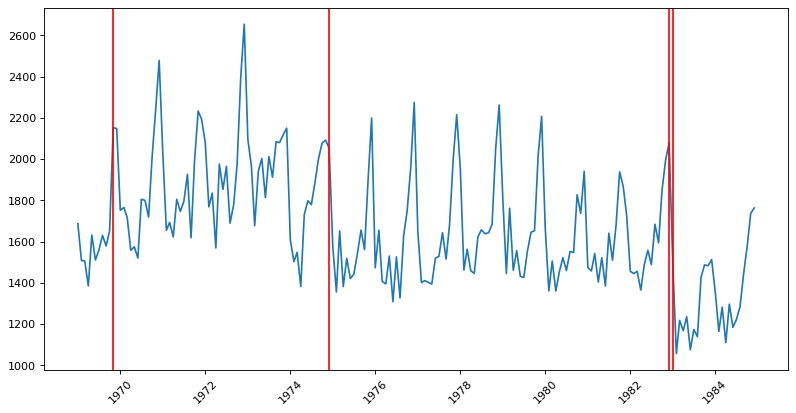

In [583]:
#--------------------------------------

from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL, # this is the default choice
    #model_parameters=[known_prec_multiplier=1.0]
    lag=1,
    changepoint_prior=.1, #prior belief
    threshold=.4
)
print(change_points)
print()

print('total changepoints--> ', len(change_points))

figure(figsize=(12, 6), dpi=80)
# Plot the data
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

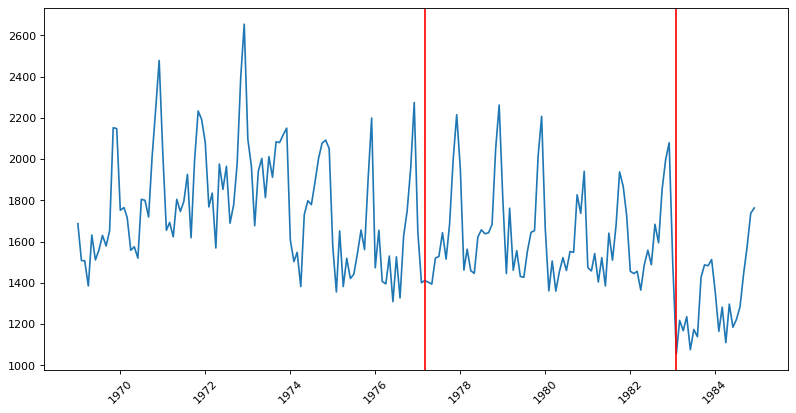

[(TimeSeriesChangePoint(start_time: 1977-03-01T00:00:00.000000000, end_time: 1977-03-01T00:00:00.000000000, confidence: 0.9803867209094156), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0e90aa00>), (TimeSeriesChangePoint(start_time: 1983-02-01T00:00:00.000000000, end_time: 1983-02-01T00:00:00.000000000, confidence: 0.9821640800352682), <kats.detectors.robust_stat_detection.RobustStatMetadata object at 0x7f2e0f4bdbe0>)]


In [588]:
#--------------------------------------

from kats.detectors.robust_stat_detection import RobustStatDetector

detector = RobustStatDetector(tsd)
change_points = detector.detector(p_value_cutoff = 2e-2)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)